In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
from bs4 import BeautifulSoup
import pandas as pd
import os

html_tables = {}

for table_name in os.listdir(r'/content/drive/MyDrive/datasets'):
    table_path = f'/content/drive/MyDrive/datasets/{table_name}'
    table_file = open(table_path, 'r')
    html = BeautifulSoup(table_file)
    html_table = html.find(id='news-table')
    html_tables[table_name] = html_table

In [20]:
tsla = html_tables['tsla_22sep.html']
tsla_tr = tsla.findAll('tr')

for i, table_row in enumerate(tsla_tr):
    link_text = table_row.a.get_text()
    data_text = table_row.td.get_text()
    print(f'{i}:')
    print(link_text)
    print(data_text)
    if i == 4:
        break

0:
Billionaire investor questions Elon Musk getting 'a pass' after bombshell tweets
Sep-21-18 09:56PM  
1:
Broadcoms Stock Looks Like a Winner
09:30PM  
2:
SHAREHOLDER ALERT:  Pomerantz Law Firm Reminds Shareholders with Losses on their Investment in Tesla, Inc. of Class Action Lawsuit and Upcoming Deadline  TSLA
05:30PM  
3:
Tesla's People Problem and the Inscrutable Musk: 2 Things That Make You Go Hmmm
05:30PM  
4:
Tesla Model 3 Crash Test Rating 2018: It Earns Top NHTSA Safety Rating
05:03PM  


**Extracting News Headlines**

In [21]:
parsed_news = []
for file_name, news_table in html_tables.items():

    for x in news_table.findAll('tr'):
        text = x.get_text()
        headline = x.a.get_text()
        date_scrape = x.td.text.split()

        if len(date_scrape) == 1:
            time = date_scrape[0]
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        ticker = file_name.split('_')[0]
        parsed_news.append([ticker, date, time, headline])

In [24]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}
vader = SentimentIntensityAnalyzer()
vader.lexicon.update(new_words)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [25]:
columns = ['ticker', 'date', 'time', 'headline']
scored_news = pd.DataFrame(parsed_news, columns=columns)
scores = [vader.polarity_scores(headline) for headline in scored_news.headline.values]
scores_df = pd.DataFrame(scores)
scored_news = pd.concat([scored_news, scores_df], axis=1)
scored_news['date'] = pd.to_datetime(scored_news.date).dt.date

<ipython-input-25-4ad419788a8d>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  scored_news['date'] = pd.to_datetime(scored_news.date).dt.date


In [26]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline

mean_c = scored_news.groupby(['date', 'ticker']).mean(numeric_only=True)
mean_c = mean_c.unstack(level=1)
mean_c = mean_c.xs('compound', axis=1)
mean_c.plot.bar()

<Axes: xlabel='date'>

In [27]:
num_news_before = scored_news.headline.count()
scored_news_clean = scored_news.drop_duplicates(['ticker', 'headline'])
num_news_after = scored_news_clean.headline.count()
f"Before we had {num_news_before} headlines, now we have {num_news_after}"

'Before we had 500 headlines, now we have 476'

In [28]:
single_day = scored_news_clean.set_index(['ticker', 'date'])
single_day = single_day.loc['fb']

if '2019-01-03' in single_day.index:
    single_day = single_day.loc['2019-01-03']
else:
    available_dates = single_day.index.unique()
    print(f"Available dates for 'fb': {available_dates}")
    if len(available_dates) > 0:
        single_day = single_day.loc[available_dates[0]]
    else:
        print("No data available for 'fb'")

Available dates for 'fb': Index([2018-09-22, 2018-09-21, 2018-09-20, 2018-09-19, 2018-09-18, 2019-01-04,
       2019-01-03, 2019-01-02, 2019-01-01, 2018-12-31, 2018-12-30, 2018-12-29,
       2018-12-28],
      dtype='object', name='date')


Text(0, 0.5, 'scores')

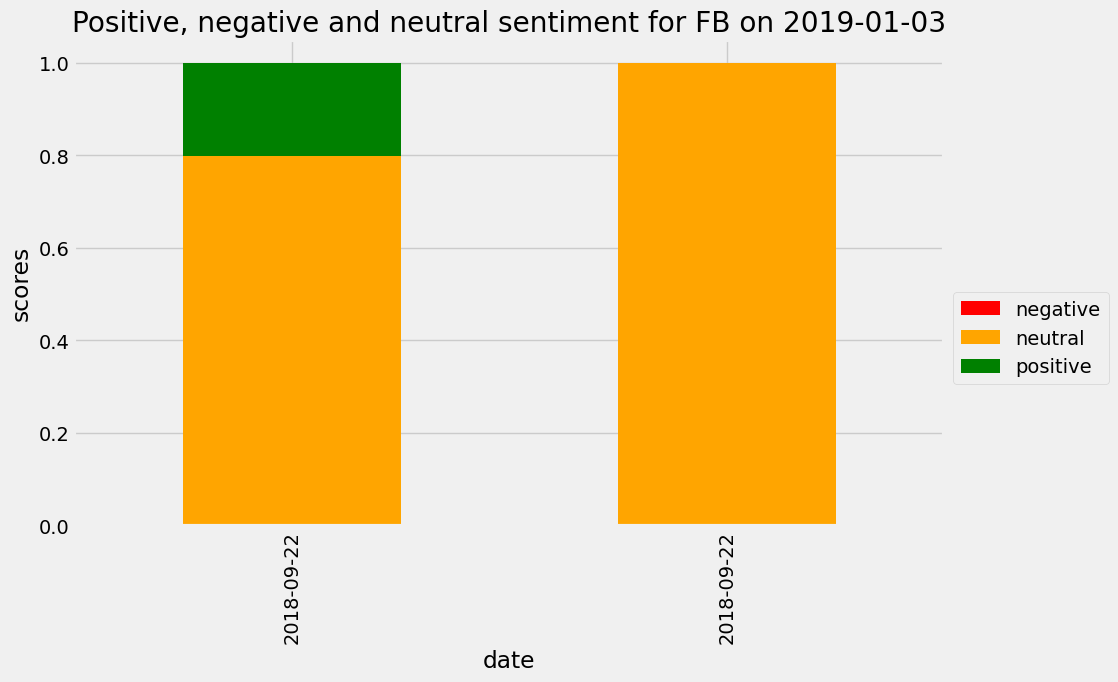

In [29]:
TITLE = "Positive, negative and neutral sentiment for FB on 2019-01-03"
COLORS = ["red", "orange", "green"]
plot_day = single_day.drop(['headline', 'compound'], axis=1)
current_columns = plot_day.columns.tolist()
new_columns = [col if col not in ['neg', 'neu', 'pos'] else {'neg': 'negative', 'neu': 'neutral', 'pos': 'positive'}.get(col, col) for col in current_columns]
plot_day.columns = new_columns

plot_day.plot.bar(stacked=True,
                  figsize=(10, 6),
                  title=TITLE,
                  color=COLORS).legend(bbox_to_anchor=(1.2, 0.5))
plt.ylabel("scores")